# Transformer Training

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from transformer_model import *
import nltk
import sys
import matplotlib.pyplot as plt
sys.path.append("../../..")

from statapp.common.preprocessing import load_all_data, encode_data, split_into_X_y

from statapp.common.sampling import sample_token_sequence

## Preprocessing

Preprocessing maison assez brouillon pour le moment... L'encodage est effectué au niveau des mots. Les données exploitées sont placées dans le dossier data dans le dossier du notebook.

In [2]:
vocab_size = 10000

In [3]:
text = load_all_data("data/fr.train.top1M.txt", sample=0.00001)

tokens = nltk.word_tokenize(text)

vocab = list(set(tokens))

In [4]:
dico = {}

for word in vocab:
    dico[word]=0
    
for token in tokens:
    dico[token]+=1
    
sorted_list = sorted(dico.items(), key=lambda x: x[1], reverse=True)

sorted_dico = {}

for i in range(min(len(sorted_list),vocab_size-1)):
    sorted_dico[sorted_list[i][0]] = sorted_list[i][1]

In [5]:
for i in range(len(tokens)):
    if tokens[i] not in sorted_dico:
        tokens[i] = "<unk>"

In [6]:
vocab = list(set(tokens))

if "<unk>" not in vocab:
    vocab.append("<unk>")
    
vocab_size = len(vocab)

vocab_numbers = dict(zip(vocab, range(0,len(vocab))))
vocab_numeroted = dict(zip(range(0,len(vocab)), vocab))
tokens_numbers = np.array([vocab_numbers[tokens[i]] for i in range(len(tokens))])

tokens_numbers_sequences = np.array([ tokens_numbers[i:i+max_length+1] for i in range(len(tokens_numbers)-max_length)])
tokens_numbers_sequences = torch.tensor(tokens_numbers_sequences , dtype=torch.int64)

nb_sequences =  tokens_numbers_sequences.shape[0]

print("Les données exploitées contiennent {} tokens (mots) au total.".format(len(tokens)))
print("La taille du vocabulaire ainsi constitué est de {}".format(vocab_size))

Les données exploitées contiennent 553 tokens (mots) au total.
La taille du vocabulaire ainsi constitué est de 270


In [9]:
#Constitution d'un jeu de test numéroté selon le vocabulaire du jeu d'entrainement

text_test = load_all_data("data/fr.train.top1M.txt", start=0.99999, sample=0.00001)

tokens_test = nltk.word_tokenize(text_test)

for i in range(len(tokens_test)):
    if tokens_test[i] not in vocab:
        tokens_test[i] = "<unk>"

tokens_numbers_test = np.array([vocab_numbers[tokens_test[i]] for i in range(len(tokens_test))])

tokens_numbers_sequences_test = np.array([ tokens_numbers_test[i:i+max_length+1] for i in range(len(tokens_numbers_test)-max_length)])
tokens_numbers_sequences_test = torch.tensor(tokens_numbers_sequences_test , dtype=torch.int64)

nb_sequences_test =  tokens_numbers_sequences_test.shape[0]

print("Les données de test exploitées contiennent {} tokens (mots) au total.".format(len(tokens_test)))

Les données de test exploitées contiennent 494 tokens (mots) au total.


In [22]:
#Affichage de la loss sur les données de test

test_output = LMtransformer(tokens_numbers_sequences_test[:,:-1])
test_loss = criterion(test_output.reshape(-1, vocab_size), tokens_numbers_sequences_test[:,1:].flatten())
print(test_loss)

tensor(6.0413, grad_fn=<NllLossBackward>)


## Apprentissage du modèle

In [23]:
LMtransformer = buildTransformer(vector_size, nb_decoders, nb_heads, head_size, ffn_hidden_size, vocab_size)
#Correspond à utiliser l'entropie croisée puisque les sorties sont des log_softmax
#et l'entropie croisée = nll_loss(log_softmax(.), target)
criterion = nn.NLLLoss()
optimizer = optim.Adam(LMtransformer.parameters(), lr=0.01)

In [24]:
def train_model(nb_epochs, batch_size):
    
    #What is this ?? I don't remember. Make grad required ?
    LMtransformer.train()
    
    #pas pour l'affichage progressif de la loss
    step = max(1,((len(tokens)-max_length-1)/batch_size)//5)
    
    epochs_losses = []
    losses = []
    test_losses = []
    
    for epoch in range(nb_epochs):
        
        running_loss = 0
        
        randperm = torch.randperm(nb_sequences)
        randperm = randperm[:(nb_sequences//batch_size)*batch_size]
        batchs_indices = randperm.reshape(nb_sequences//batch_size, batch_size)
        
        for i, batch_indices in enumerate(batchs_indices):
            
            batch = tokens_numbers_sequences[batch_indices]
            optimizer.zero_grad()
            output = LMtransformer(batch[:,:-1])
            loss = criterion(output.reshape(-1, vocab_size), batch[:,1:].flatten())

            loss.backward()
            optimizer.step()
            
            #Il faudrait adapter les affichages en fonction du nombre de batchs total
            running_loss += loss.item()
            if i % step == step-1:
                
                #Calcul de la loss sur les données de test
                test_output = LMtransformer(tokens_numbers_sequences_test[:,:-1])
                test_loss = criterion(test_output.reshape(-1, vocab_size), tokens_numbers_sequences_test[:,1:].flatten())
                
                print('[%d, %5d] loss: %.3f ; test_loss : %.3f' %
                      (epoch + 1, i + 1, running_loss / step, test_loss))
                
                #stock pour affichage graphique
                epochs_losses.append(epoch-1+(i/((len(tokens)-max_length-1)/batch_size)))
                losses.append(running_loss / step)
                test_losses.append(test_loss)
                
                running_loss = 0.
                
        plt.plot(epochs_losses, losses)
        plt.plot(epochs_losses, test_losses)

Test d'overfitting sur un cas ultrasimplifié (5 tokens, longueur de séquence 1, 3 decoders, 2 heads) :
- En observant les sorties le modèle a bien appris et overfitte ! (loss à 0 au bout de 5-6 epochs) 

[1,    10] loss: 4.802 ; test_loss : 5.790
[1,    20] loss: 3.198 ; test_loss : 6.746
[1,    30] loss: 2.637 ; test_loss : 7.218
[1,    40] loss: 1.965 ; test_loss : 7.667
[1,    50] loss: 1.437 ; test_loss : 8.793
[2,    10] loss: 1.102 ; test_loss : 8.929
[2,    20] loss: 1.049 ; test_loss : 9.674
[2,    30] loss: 0.891 ; test_loss : 9.261
[2,    40] loss: 1.004 ; test_loss : 9.522
[2,    50] loss: 0.961 ; test_loss : 9.979
[3,    10] loss: 0.671 ; test_loss : 10.090
[3,    20] loss: 0.735 ; test_loss : 10.328
[3,    30] loss: 0.673 ; test_loss : 10.297
[3,    40] loss: 0.688 ; test_loss : 10.752
[3,    50] loss: 0.711 ; test_loss : 11.376
[4,    10] loss: 0.615 ; test_loss : 11.515
[4,    20] loss: 0.584 ; test_loss : 9.819
[4,    30] loss: 0.596 ; test_loss : 10.689
[4,    40] loss: 0.639 ; test_loss : 10.375
[4,    50] loss: 0.660 ; test_loss : 9.952
[5,    10] loss: 0.507 ; test_loss : 10.522
[5,    20] loss: 0.532 ; test_loss : 10.844
[5,    30] loss: 0.590 ; test_loss : 11.390


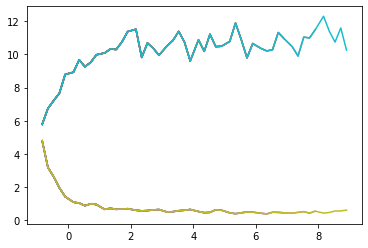

In [25]:
train_model(10,10)

## Sauvegarde des paramètres du modèle obtenu

In [26]:
#Un dico  des hyperparams serait pratique ^^
torch.save({
    "nb_decoders" : nb_decoders,
    "vector_size" : vector_size,
    "nb_heads" : nb_heads,
    "head_size" : head_size,
    "max_length" : max_length,
    "ffn_hidden_size" : ffn_hidden_size,
    "vocab_size" : vocab_size,
    "model_params_dict" : LMtransformer.state_dict()}
    ,
    "params/LMtfparams"+str(np.random.rand())[2:])

In [2]:
#Later to restore:
lp = torch.load("params/LMtfparams7455419561970809")

nb_decoders = lp["nb_decoders"]
vector_size = lp["vector_size"]
nb_heads = lp["nb_heads"]
head_size = lp["head_size"]
max_length = lp["max_length"]
ffn_hidden_size = lp["ffn_hidden_size"]
vocab_size = lp["vocab_size"]
model_params_dict = lp["model_params_dict"]

LMtransformer = buildTransformer(vector_size, nb_decoders, nb_heads, head_size, ffn_hidden_size, vocab_size)
LMtransformer.load_state_dict(model_params_dict)

#Attention, pour pouvoir générer il faut reconstruire le vocabulaire et ses numéros associés avec le code plus haut

{'nb_decoders': 2, 'vector_size': 64, 'nb_heads': 4, 'head_size': 16, 'max_length': 8, 'ffn_hidden_size': 256, 'vocab_size': 269, 'model_params_dict': OrderedDict([('decoders.0.multihead_attention.w_q.weight', tensor([[-0.0252, -0.4441, -0.1588,  ..., -0.0376, -0.2381,  0.1855],
        [-0.2052, -0.3539,  0.1468,  ..., -0.3383,  0.1778,  0.0463],
        [-0.1713, -0.0288, -0.0151,  ..., -0.0672, -0.1919,  0.0813],
        ...,
        [-0.0639,  0.2691,  0.2535,  ..., -0.1409, -0.0648,  0.1145],
        [ 0.1918,  0.4472,  0.1806,  ..., -0.0150,  0.1312,  0.2238],
        [-0.0716,  0.2197, -0.1720,  ..., -0.0398, -0.1060, -0.1057]])), ('decoders.0.multihead_attention.w_q.bias', tensor([ 0.4162,  0.1516, -0.0395, -0.1261,  0.0252,  0.2988,  0.2507,  0.0060,
        -0.0243, -0.0673, -0.0181,  0.0653, -0.0703,  0.0041, -0.2356, -0.2741,
         0.2428, -0.0064, -0.0293,  0.2388,  0.0524,  0.0410, -0.1274, -0.2394,
        -0.1074,  0.1023,  0.0365, -0.2920, -0.0632, -0.1428,  0.1021,

        -1.7814e-01, -1.0464e-01,  5.5313e-02, -4.9438e-02]))])}


<All keys matched successfully>

## Génération

In [27]:
#bidouilles pour adapter nos fonctions aux fonctions common codées par Nathra 
#(sequence list of ints en entree, list of probas en sortie)
#(Faire mieux plus tard)
def LMtransformerprediction(listints):
    return np.exp(LMtransformer(torch.tensor([listints[-8:]]))[0][-1].tolist())

In [28]:
def gen_seq(prev_seq, top_k=5):
    with torch.no_grad():
        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]
        sample_token_seq = sample_token_sequence(LMtransformerprediction, prev_seq_numbers, top_k=top_k)
        tokens_pred = [vocab_numeroted[i] for i in sample_token_seq]
        print(' '.join(tokens_pred)) 

In [29]:
"""def gen_seq_maison(prev_seq):
    with torch.no_grad():
        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]
        indice = np.argmax(np.array(LMtransformer(torch.tensor([prev_seq_numbers]))))
        tokens_pred = vocab_numeroted[indice]
        print(' '.join(tokens_pred))"""

"def gen_seq_maison(prev_seq):\n    with torch.no_grad():\n        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]\n        indice = np.argmax(np.array(LMtransformer(torch.tensor([prev_seq_numbers]))))\n        tokens_pred = vocab_numeroted[indice]\n        print(' '.join(tokens_pred))"

In [30]:
gen_seq(['il'])

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 90.77it/s]


lui arrive parfois d ' entrer dans une maison , ou de s ' ma liberte de la ruthenie qui dure depuis plusieurs annees . ainsi , en 1281 , les polonais mer de la reochestration de trois de commerce et d ' industrie d ' artistes comme pierre dac , fernand raynaud ou jacques brel ... il fut egalement un historien loc , vive ma armee praxis a cagnes et , fort de vitoria-gasteiz pour aller aider leon ier de galicie . l ' histoire de la commune de tusson de contes pour enfants , brocanteur , ami d


In [31]:
gen_seq(['a','l','age','de','31'], top_k=1)

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 84.27it/s]


ans , a barcelone , il est touche par l ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est alors persuade d ' avoir atteint , par la meditation des lettres et des nombres , l ' inspiration prophetique et l ' etat de messie . il quitte a nouveau l ' espagne afin de transmettre , fort de l ' essence divine qui l ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est alors persuade d ' avoir atteint , par la meditation des lettres


In [32]:
gen_seq(['<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>'], top_k=1)

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 95.01it/s]


... en 1981 , mer . non content d ' exercer son sacerdoce , roger ducouret fut auteur de romans policiers , de contes pour enfants , brocanteur , ami d ' artistes comme pierre dac , fernand raynaud ou jacques brel ... il fut , l ' , les gens de maintenant de vitoria-gasteiz , dont l ' aeroport se met a se specialiser dans le traitement de charge aerienne et , formee par aena , la mairie de vitoria-gasteiz , dont l ' aeroport se met a se specialiser dans le traitement de charge aerienne et , formee


In [33]:
gen_seq(['barcelone',',','il','est','touche','par','l'])

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 88.01it/s]


' esprit prophetique apres avoir ete marquee apres a ete marquee par la personnalite roger ducouret , cue de tusson de 1942 a 1981 . non content d ' exercer son sacerdoce , roger ducouret fut auteur de romans policiers , de contes pour favoriser cette activite , on constitue en 1994 la societe via , formee par aena , la un historien loc de contes pour aller aider leon ier de galicie . l ' histoire de la commune de tusson de 1942 a 1981 de serge gainsbourg et `` vive ma liberte `` d ' arno . il


In [34]:
if len(tokens)<100:
    print(' '.join(tokens))